# 21기 Clustering 정규세션 과제

**데이터:** [Mall Customer Segmentation Data| Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

---

## 0. 데이터 불러오기

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from sklearn.metrics import silhouette_score

In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/ToBigs/05. KNN&Clustering/과제/Clustering/Mall_Customers.csv", index_col = 0)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


## 1. Preprocssing / EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [ ]:
df.isna().sum() # 결측치 0

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [ ]:
df.duplicated().sum() # 중복 없음 확인

0

클러스터 넘버 빠르게 확인하기 위해 PCA 적용

In [ ]:
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender']) # 혼자 category

ss = StandardScaler()
X_scaled = ss.fit_transform(df.values)
X_scaled = pd.DataFrame(X_scaled, columns=df.columns)

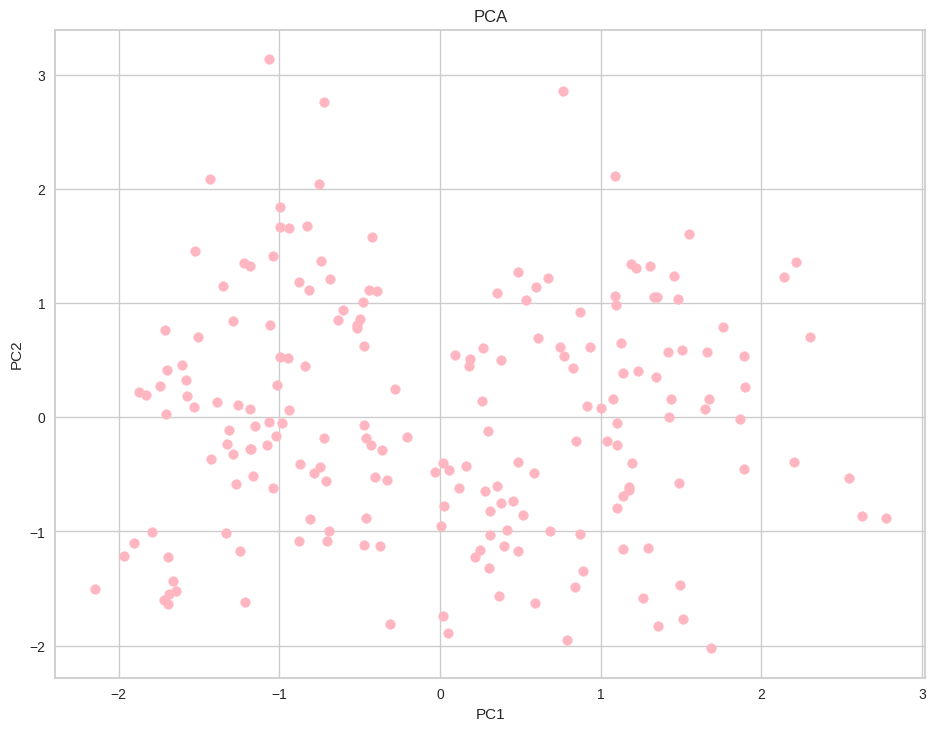

In [ ]:
pca_result = PCA(n_components=2).fit_transform(X_scaled)

# Plot PCA results
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='lightpink')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA")
plt.show()

클러스터로 나누기 쉽지 않아 보여 t-SNE도 진행

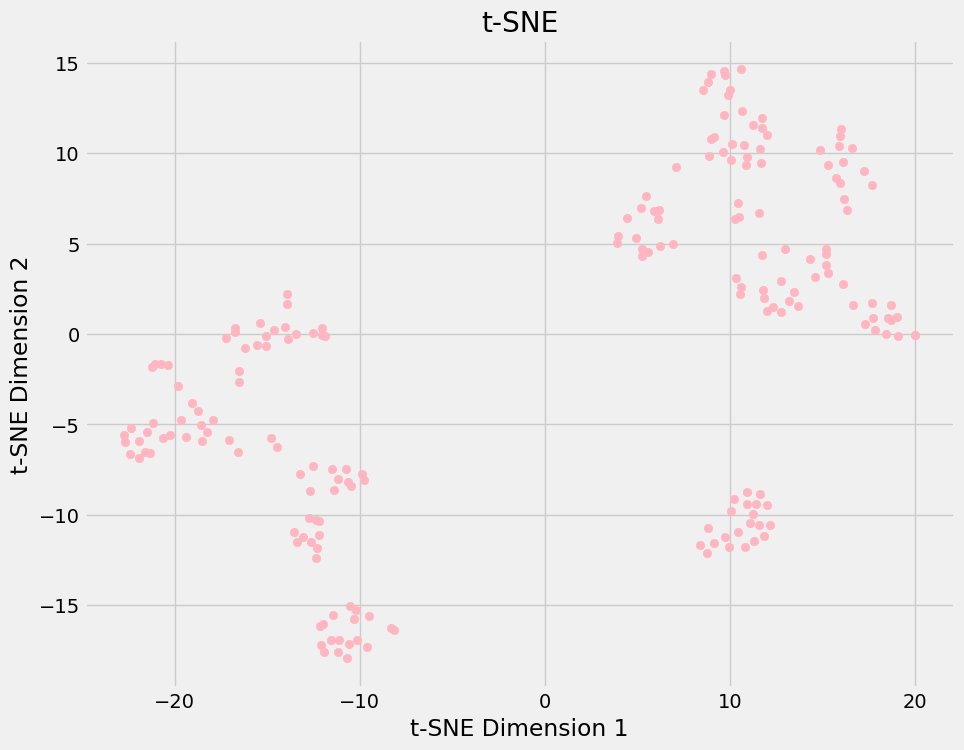

In [ ]:
# t-SNE

tsne_result = TSNE(perplexity=20).fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='lightpink')
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE")
plt.show()

그룹으로 나뉘어지나 정확히 몇 그룹인지 불명확

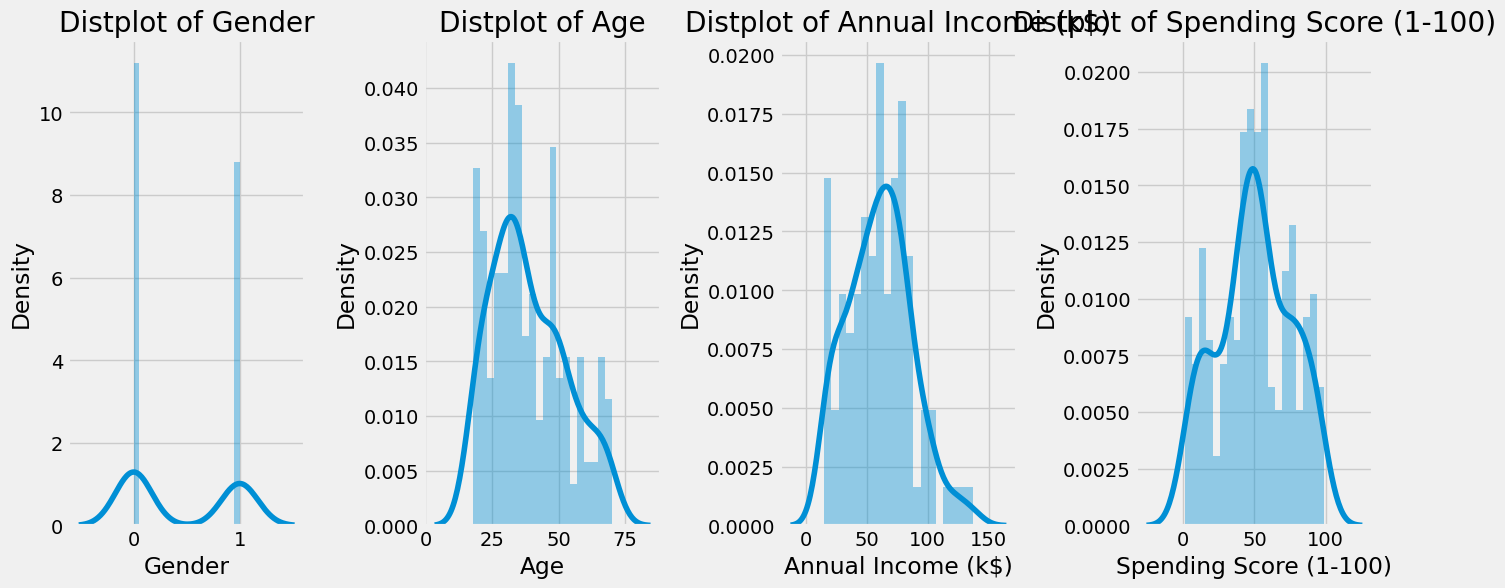

In [ ]:
plt.style.use('fivethirtyeight')

plt.figure(1 , figsize = (15 , 6))
n = 0
for x in df.columns:
    n += 1
    plt.subplot(1 , 4 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

## 2. Clustering

K-means clustering

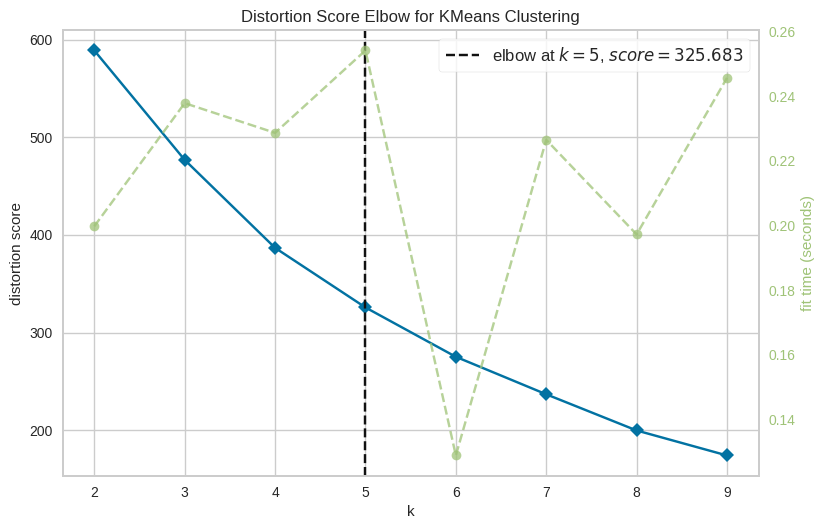

In [ ]:
inertias = []
K_range = range(2, 10)


kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,10))

visualizer.fit(X_scaled)
visualizer.show()
plt.show()

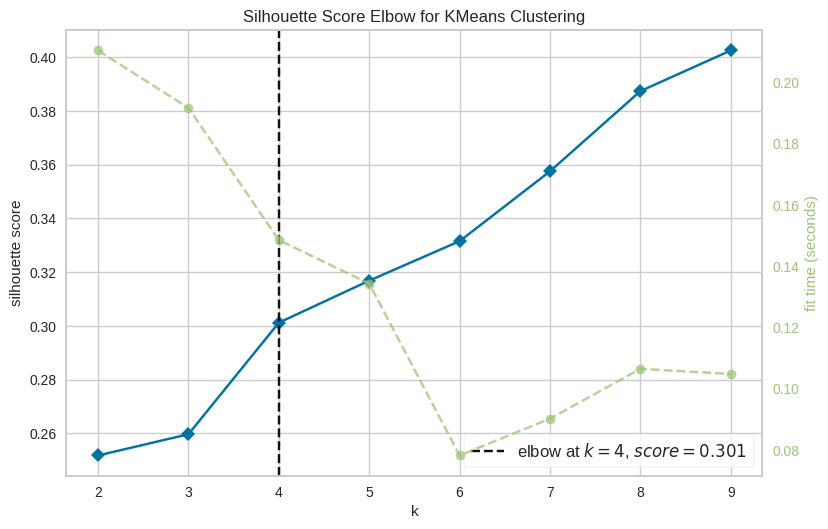

In [ ]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(X_scaled)
visualizer.show()
plt.show()

Elbow method은 cluster 5개를, silhouette에서는 4개로 추천한다. Session에서 silhouette 지수를 다루었기에 4개로 진행한다.

In [ ]:
# fixed
n_clusters = 4

In [ ]:
KM_4_clusters = KMeans(n_clusters= n_clusters, init='k-means++').fit(X_scaled)
KM4_clustered = X_scaled.copy()
KM4_clustered.loc[:,'Cluster'] = KM_4_clusters.labels_ # append labels to points

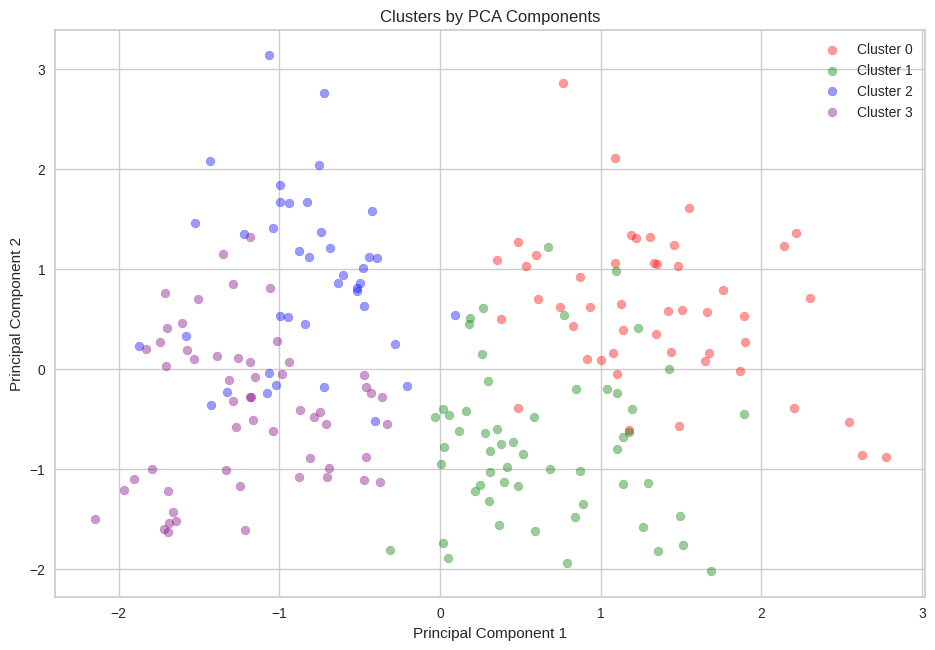

In [ ]:
pca_df = pd.DataFrame(data=pca_result, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Cluster'] = KM_4_clusters.labels_

# Plotting
plt.figure(figsize=(10, 7))
plt.title('Clusters by PCA Components')

# Color code by cluster
colors = ['red', 'green', 'blue', 'purple', 'orange']
for cluster in range(n_clusters):
    clustered_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(clustered_data['Principal Component 1'], clustered_data['Principal Component 2'],
                color=colors[cluster], s=40, alpha=0.4, label=f'Cluster {cluster}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


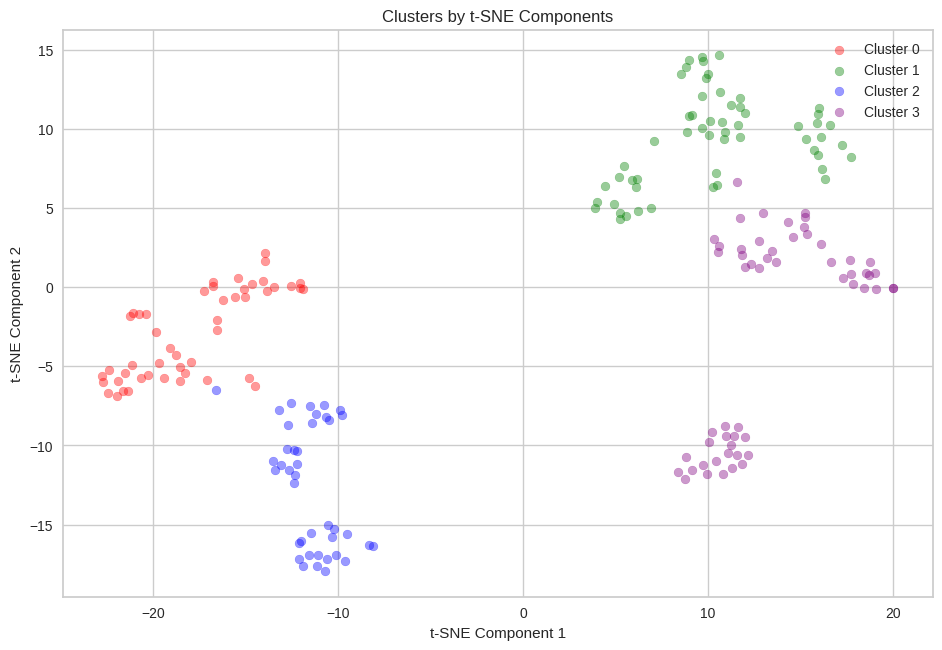

In [ ]:
tsne_df = pd.DataFrame(data=tsne_result, columns=['t-SNE Component 1', 't-SNE Component 2'])
tsne_df['Cluster'] = KM_4_clusters.labels_


plt.figure(figsize=(10, 7))
plt.title('Clusters by t-SNE Components')


colors = ['red', 'green', 'blue', 'purple', 'orange']
for cluster in range(n_clusters):
    clustered_data = tsne_df[tsne_df['Cluster'] == cluster]
    plt.scatter(clustered_data['t-SNE Component 1'], clustered_data['t-SNE Component 2'],
                color=colors[cluster], s=40, alpha=0.4, label=f'Cluster {cluster}')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid(True)
plt.show()


## 3. Evaluation

In [ ]:
score = silhouette_score(X_scaled, KM_4_clusters.labels_)
print(f"Silhouette Score: {score:.2f}")

Silhouette Score: 0.30


실루엣 점수 0.30은 가장 잘 분리되었음을 나타내는 1과 거리가 있기에 좋은 점수는 아니기에 기존 엘보우 방법으로 다시 한번 k-means 진행하여 점수를 비교합니다.

In [ ]:
n_clusters = 5

In [ ]:
KM_5_clusters = KMeans(n_clusters= n_clusters, init='k-means++').fit(X_scaled)
KM5_clustered = X_scaled.copy()
KM5_clustered.loc[:,'Cluster'] = KM_5_clusters.labels_

In [ ]:
score = silhouette_score(X_scaled, KM_5_clusters.labels_)
print(f"Silhouette Score: {score:.2f}")

Silhouette Score: 0.32


점수가 조금 상향됐습니다.